In [14]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2

# CLASSIFICATION

In [3]:
class VideosDataset(Sequence):
    def __init__(self, image_dir, annotation_dir, label_encoder, transform=None, batch_size=32):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.label_encoder = label_encoder
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []

        for img_name in batch_files:
            img_path = os.path.join(self.image_dir, img_name)

            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                # print(f"Error opening image {img_name}: {e}")
                continue

            annotation_name = img_name.replace('.jpg', '.csv')
            annotation_path = os.path.join(self.annotation_dir, annotation_name)

            try:
                annotation = pd.read_csv(annotation_path, header=None)
            except Exception as e:
                # print(f"Error reading {annotation_name}: {e}")
                annotation = pd.DataFrame()

            if annotation.empty:
                label = self.label_encoder.transform(['empty'])[0]
                if self.transform:
                    image = self.transform(image)
                images.append(np.array(image))
                labels.append(label)
                continue

            for _, line in annotation.iterrows():
                try:
                    label_str = line[4]
                    if label_str != 'empty':
                        x1 = int(line[0])
                        y1 = int(line[1])
                        x2 = int(line[2])
                        y2 = int(line[3])
                        roi = image.crop((x1, y1, x2, y2))
                    else:
                        roi = image
                except Exception as e:
                    # print(f"Error processing annotation {annotation_name}: {e}")
                    continue

                if self.transform:
                    roi = self.transform(roi)

                label = self.label_encoder.transform([label_str])[0]
                images.append(np.array(roi))
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

In [4]:
def transform(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    return image

In [5]:
image_dir = 'train/images2'
annotation_dir = 'train/labels2'

annotations = ['ff']
for filename in os.listdir(annotation_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(annotation_dir, filename)
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty:
                annotations.extend(df.iloc[:, 4].values)
        except Exception as e:
            pass

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(annotations)

LabelEncoder()

In [7]:
train_dataset = VideosDataset(image_dir='train/images2',
                              annotation_dir='train/labels2',
                              label_encoder=label_encoder,
                              transform=transform,
                              batch_size=32)

val_dataset = VideosDataset(image_dir='val/images',
                            annotation_dir='val/labels',
                            label_encoder=label_encoder,
                            transform=transform,
                            batch_size=32)

In [8]:
num_classes = len(label_encoder.classes_)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
num_epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/10


2024-06-22 23:52:52.200046: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


34/34 [==============================] - 18s 508ms/step - loss: 1.8544 - accuracy: 0.3810 - val_loss: 0.9396 - val_accuracy: 0.7721
Epoch 2/10
34/34 [==============================] - 14s 419ms/step - loss: 0.7121 - accuracy: 0.7859 - val_loss: 0.4539 - val_accuracy: 0.8382
Epoch 3/10
34/34 [==============================] - 14s 420ms/step - loss: 0.4542 - accuracy: 0.8559 - val_loss: 0.3968 - val_accuracy: 0.9191
Epoch 4/10
34/34 [==============================] - 14s 421ms/step - loss: 0.3572 - accuracy: 0.8882 - val_loss: 0.3769 - val_accuracy: 0.9485
Epoch 5/10
34/34 [==============================] - 20s 571ms/step - loss: 0.2885 - accuracy: 0.9055 - val_loss: 0.3717 - val_accuracy: 0.9412
Epoch 6/10
34/34 [==============================] - 17s 484ms/step - loss: 0.2370 - accuracy: 0.9228 - val_loss: 0.3098 - val_accuracy: 0.9485
Epoch 7/10
34/34 [==============================] - 15s 443ms/step - loss: 0.2181 - accuracy: 0.9246 - val_loss: 0.2995 - val_accuracy: 0.9559
Epoch 8/10

In [9]:
model.save('model.h5')

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

NameError: name 'history' is not defined

In [11]:
# show 10 random images from the validation set
val_images, val_labels = val_dataset.__getitem__(0)
val_predictions = model.predict(val_images)
val_predictions = np.argmax(val_predictions, axis=1)

2024-06-23 10:21:04.081577: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 28ms/step


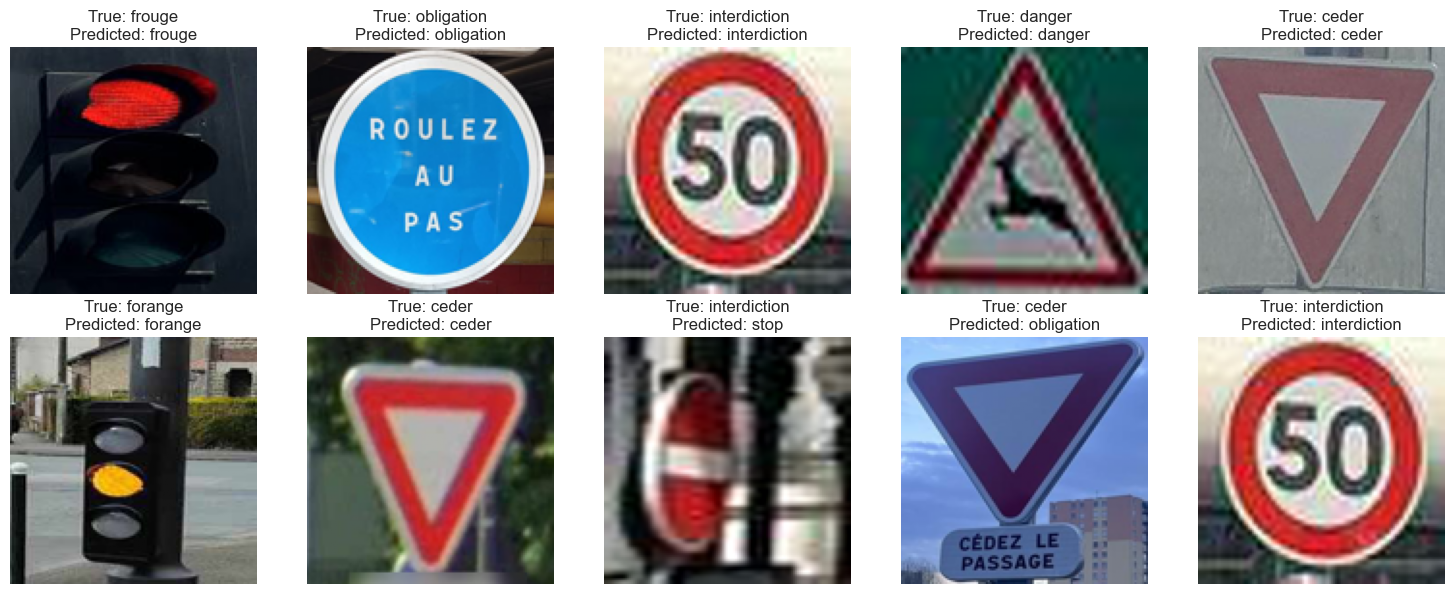

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(val_images))
    ax.imshow(val_images[idx])
    ax.set_title(f"True: {label_encoder.classes_[val_labels[idx]]}\nPredicted: {label_encoder.classes_[val_predictions[idx]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# DETECTION

In [30]:
class DetectionDataset(Sequence):
    def __init__(self, image_dir, annotation_dir, transform=None, batch_size=32):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        bboxes = []

        for img_name in batch_files:
            img_path = os.path.join(self.image_dir, img_name)

            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                continue

            annotation_name = img_name.replace('.jpg', '.csv')
            annotation_path = os.path.join(self.annotation_dir, annotation_name)

            try:
                annotation = pd.read_csv(annotation_path, header=None)
            except Exception as e:
                annotation = pd.DataFrame()

            if annotation.empty:
                continue

            if self.transform:
                image = self.transform(image)

            for _, line in annotation.iterrows():
                try:
                    if line[4] == 'empty':
                        continue
                    x1 = int(line[0])
                    y1 = int(line[1])
                    x2 = int(line[2])
                    y2 = int(line[3])
                    bbox = [x1, y1, x2, y2]
                except Exception as e:
                    continue

                images.append(np.array(image))
                bboxes.append(bbox)

        images = np.array(images)
        bboxes = np.array(bboxes)
        return images, bboxes

In [31]:
def transform(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    return image

In [32]:
image_dir = 'train/images2'
annotation_dir = 'train/labels2'

In [33]:
train_dataset = DetectionDataset(image_dir=image_dir,
                                 annotation_dir=annotation_dir,
                                 transform=transform,
                                 batch_size=32)

val_dataset = DetectionDataset(image_dir='val/images',
                                 annotation_dir='val/labels',
                                 transform=transform,
                                 batch_size=32)

In [74]:
detection_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4)
])

In [75]:
detection_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

In [76]:
num_epochs = 10
history = detection_model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/10
34/34 [==============================] - 20s 566ms/step - loss: 65029.8594 - mse: 65029.8594 - val_loss: 83166.0469 - val_mse: 83166.0469
Epoch 2/10
34/34 [==============================] - 17s 481ms/step - loss: 38934.0898 - mse: 38934.0898 - val_loss: 66430.6484 - val_mse: 66430.6484
Epoch 3/10
34/34 [==============================] - 18s 510ms/step - loss: 38775.7656 - mse: 38775.7656 - val_loss: 86855.2031 - val_mse: 86855.2031
Epoch 4/10
34/34 [==============================] - 19s 546ms/step - loss: 38818.7539 - mse: 38818.7539 - val_loss: 85177.7891 - val_mse: 85177.7891
Epoch 5/10
34/34 [==============================] - 18s 514ms/step - loss: 35718.8086 - mse: 35718.8086 - val_loss: 80209.1641 - val_mse: 80209.1641
Epoch 6/10
34/34 [==============================] - 19s 549ms/step - loss: 35138.9922 - mse: 35138.9922 - val_loss: 74856.8594 - val_mse: 74856.8594
Epoch 7/10
34/34 [==============================] - 18s 528ms/step - loss: 34839.6094 - mse: 34839.6094 - 

In [77]:
detection_model.save('detection_model.h5')

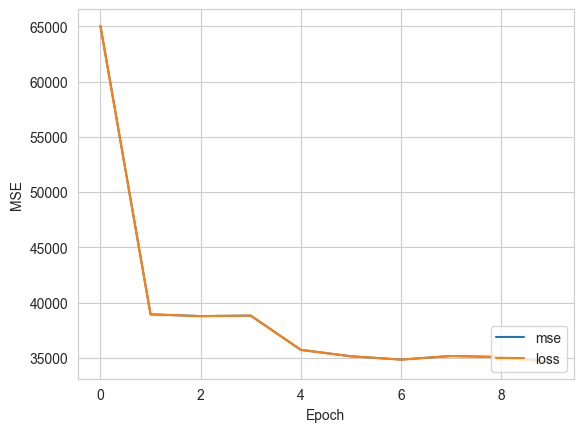

In [78]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

In [79]:
train_images, train_bboxes = train_dataset.__getitem__(0)
train_predictions = detection_model.predict(train_images)

2/2 [==============================] - 0s 34ms/step


# Detect and Classify

In [80]:
def detect_and_classify(image_path, detection_model, classification_model, transform):
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image)
    transformed_image = np.expand_dims(transformed_image, axis=0)

    # Detect bounding boxes
    bboxes = detection_model.predict(transformed_image)[0]

    x1, y1, x2, y2 = map(int, bboxes)
    roi = image.crop((x1, y1, x2, y2))
    roi = transform(roi)
    roi = np.expand_dims(roi, axis=0)

    # Classify the ROI
    label_idx = classification_model.predict(roi).argmax(axis=-1)
    label = label_encoder.inverse_transform([label_idx])[0]

    return bboxes, label

In [81]:
detection_model = tf.keras.models.load_model('detection_model.h5')
classification_model = tf.keras.models.load_model('model.h5')

In [84]:
image_path = 'val/images/0709.jpg'
bboxes, label = detect_and_classify(image_path, detection_model, classification_model, transform)

1/1 [==============================] - 0s 28ms/step


/Users/adriensimon/anaconda3/envs/sy32/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


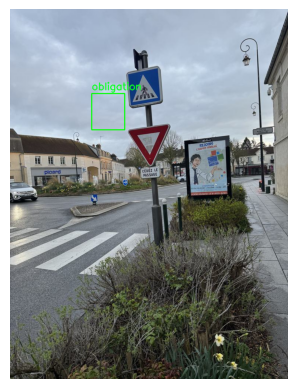

In [85]:
image = cv2.imread(image_path)
x1, y1, x2, y2 = map(int, bboxes)
cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()